In [65]:
# add parent dir to sys.path so we can import from repo base
import os; import sys; sys.path.append(os.path.dirname(os.path.realpath(os.getcwd())))

In [67]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from definitions import model_dir
from script.dataset import get_data, cols_emg, cols_emg_cal
from script.visualization import report_cm

In [69]:
X, y = get_data(simplify=True)

In [71]:
# extract center 100 data points from each set & one-hot encode labels

window_size = 100
data = list()
labels = list()
people = list()

for i, count in X.value_counts('id').items():
    start = int(count / 2 - window_size / 2)
    idx_range = X[X['id'] == i].index[start:start + window_size]
    data.append(np.array(X.iloc[idx_range][cols_emg + cols_emg_cal]))
    labels.append(y[i])
    people.append(i.split('_')[1])
    
data = np.array(data)
data_dim = data.shape
print(f'data shape: {data_dim}')

scaler = StandardScaler()
data = data.reshape(-1, 8)  # reshape to 2D for scaling
data = scaler.fit_transform(data)
data = data.reshape(*data_dim)  # reshape back to original shape

encoder = OneHotEncoder(sparse_output=False)
labels = encoder.fit_transform(np.array(labels).reshape(-1, 1))
print(f'labels shape: {labels.shape}, classes: {encoder.categories_}')

people = pd.Series(people)

data shape: (312, 100, 16)
labels shape: (312, 2), classes: [array(['crimp', 'sloper_jug'], dtype='<U10')]


In [73]:
# train/test split

test_person = 'p1'
split = people == test_person
data_train, data_test, labels_train, labels_test = data[~split], data[split], labels[~split], labels[split]
print(f'training data shape: {data_train.shape}')

training data shape: (232, 100, 16)


In [75]:
# pytorch device & tensors

# use gpu > apple silicon > cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else (torch.device("mps") if torch.backends.mps.is_available() else "cpu"))

def dataset_to_tensors(data, labels):   
    data = torch.tensor(data, dtype=torch.float32, device=device)
    # change dimensions to (batch_size, num_features, seq_length)
    data = data.transpose(1, 2)
    labels = torch.tensor(labels, dtype=torch.float32, device=device)
    return (data, labels)

data_train, labels_train = dataset_to_tensors(data_train, labels_train)
data_test, labels_test = dataset_to_tensors(data_test, labels_test)

In [77]:
# network

class CNN(nn.Module):
    def __init__(self, seq_length, kernel_size = 5, num_features = 32, in_channels = 16, classes = 4):
        super(CNN, self).__init__()

        conv_diff = kernel_size - 1
        lin_in = int(((seq_length - conv_diff) / 2 - conv_diff) / 2 * num_features)
        conv1_feats = int(in_channels + (num_features - in_channels) / 2)
        
        self.stack = nn.Sequential(
            nn.Conv1d(in_channels=in_channels, out_channels=conv1_feats, kernel_size=kernel_size),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            
            nn.Conv1d(in_channels=conv1_feats, out_channels=num_features, kernel_size=kernel_size),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),

            nn.Dropout(0.5),
            nn.Flatten(),
            nn.Linear(lin_in, classes),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        i = torch.nn.Identity()
        c = i(x)
        c = self.stack(c)
        return c

model = CNN(window_size, classes=labels.shape[1])
print(f'number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')
del model

number of parameters: 7226


In [79]:
# training

train = True


num_k_folds = 10
num_epochs = 20
learning_rate = 0.001
batch_size = 8

epoch_nums = []
validation_losses = []
accuracies_list = []
recalls_list = []
fscores_list = []
min_losses = []
max_losses = []
min_accuracies = []
max_accuracies = []

# model save
model_path = os.path.join(model_dir, 'cnn.pth')

def train_epoch(model, optimizer, criterion, dataloader):
    model.train()
    running_loss = 0
    
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
    # epoch loss
    return running_loss / len(dataloader.dataset)

def train(model, optimizer, criterion, data, labels, num_epochs = num_epochs, batch_size=batch_size):
    # data loading
    dataset = TensorDataset(data_train, labels_train)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    best_loss = float('inf')
    for epoch in range(num_epochs):
        epoch_loss = train_epoch(model, optimizer, criterion, dataloader)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')
        
        # save best model
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(model.state_dict(), model_path)
    print('Training complete')

    
def test(model, criterion, dataloader):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    total_precision = 0
    total_recall = 0

    # We need confusion matrix components to compute precision and recall
    TP = 0  # True Positive
    FP = 0  # False Positive
    FN = 0  # False Negative

    for inputs, labels in dataloader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * inputs.size(0)
        
        # Convert one-hot labels to indices if necessary
        if labels.dim() > 1 and labels.size(1) > 1:
            labels = torch.argmax(labels, dim=1)

        _, predicted = torch.max(outputs, 1)
        
        # Now compare predicted class indices with label class indices
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        for i in range(len(labels)):
            if labels[i] == predicted[i] == 1:
                TP += 1
            if predicted[i] == 1 and labels[i] != predicted[i]:
                FP += 1
            if predicted[i] == 0 and labels[i] != predicted[i]:
                FN += 1

    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return avg_loss, accuracy, precision, recall, f1_score
    
if not train:
    print('Skipping training')
else:
    kf = KFold(n_splits=num_k_folds)
    best_loss = float('inf')
    for fold, (idx_train, idx_val) in enumerate(kf.split(data_train)):
        d_train, d_val = data_train[idx_train], data_train[idx_val]
        l_train, l_val = labels_train[idx_train], labels_train[idx_val]
        
        model = CNN(window_size, classes=l_train.shape[1]).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        train(model, optimizer, criterion, d_train, l_train)
        
        model.eval()
        with torch.no_grad():
            outputs = model(d_val)
            val_loss = criterion(outputs, l_val).item()
            print(f'Validation Loss: {val_loss:.4f}')
            # save best model
            if val_loss < best_loss:
                best_loss = val_loss
                torch.save(model.state_dict(), model_path)
        
        # Create dataloader for testing
        test_dataset = TensorDataset(data_test, labels_test)
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # Test the model
        test_loss, test_accuracy, test_precision, test_recall, test_f1_score = test(model, criterion, test_dataloader)

        # Append results to respective lists
        validation_losses.append(val_loss)
        accuracies_list.append(test_accuracy)
        recalls_list.append(test_recall)
        fscores_list.append(test_f1_score)
        #min_losses.append(min(min_losses, test_loss, default=test_loss))
        #max_losses.append(max(max_losses, test_loss, default=test_loss))
        #min_accuracies.append(min(min_accuracies, test_accuracy, default=test_accuracy))
        #max_accuracies.append(max(max_accuracies, test_accuracy, default=test_accuracy))
        
    print(f'Best validation loss: {best_loss}')



Epoch 1/20, Loss: 0.5873
Epoch 2/20, Loss: 0.4220
Epoch 3/20, Loss: 0.3874
Epoch 4/20, Loss: 0.3783
Epoch 5/20, Loss: 0.4042
Epoch 6/20, Loss: 0.3663
Epoch 7/20, Loss: 0.3695
Epoch 8/20, Loss: 0.3693
Epoch 9/20, Loss: 0.3606
Epoch 10/20, Loss: 0.3534
Epoch 11/20, Loss: 0.3638
Epoch 12/20, Loss: 0.3531
Epoch 13/20, Loss: 0.3487
Epoch 14/20, Loss: 0.3629
Epoch 15/20, Loss: 0.3535
Epoch 16/20, Loss: 0.3398
Epoch 17/20, Loss: 0.3406
Epoch 18/20, Loss: 0.3472
Epoch 19/20, Loss: 0.3400
Epoch 20/20, Loss: 0.3377
Training complete
Validation Loss: 0.3141
Epoch 1/20, Loss: 0.6276
Epoch 2/20, Loss: 0.4746
Epoch 3/20, Loss: 0.4310
Epoch 4/20, Loss: 0.4129
Epoch 5/20, Loss: 0.3958
Epoch 6/20, Loss: 0.3829
Epoch 7/20, Loss: 0.3849
Epoch 8/20, Loss: 0.3756
Epoch 9/20, Loss: 0.3810
Epoch 10/20, Loss: 0.3727
Epoch 11/20, Loss: 0.3685
Epoch 12/20, Loss: 0.3585
Epoch 13/20, Loss: 0.3691
Epoch 14/20, Loss: 0.3626
Epoch 15/20, Loss: 0.3614
Epoch 16/20, Loss: 0.3568
Epoch 17/20, Loss: 0.3544
Epoch 18/20, L

In [81]:
# Create a DataFrame for Test-Performance-Per-Fold
performance_data = {
    "K-Fold": list(range(1, num_k_folds + 1)),
    "CNN_Accuracy": accuracies_list,
    "CNN_Recall": recalls_list,
    "CNN_FScore": fscores_list
}
df = pd.DataFrame(performance_data)

# Save to CSV for Test-Performance-Per-Fold
csv_path = 'cnn_test_performance_per_fold.csv'
df.to_csv(csv_path, index=False)
print(f'Results saved to {csv_path}')

Results saved to cnn_test_performance_per_fold.csv


# Testing with p1

accuracy: 0.9875


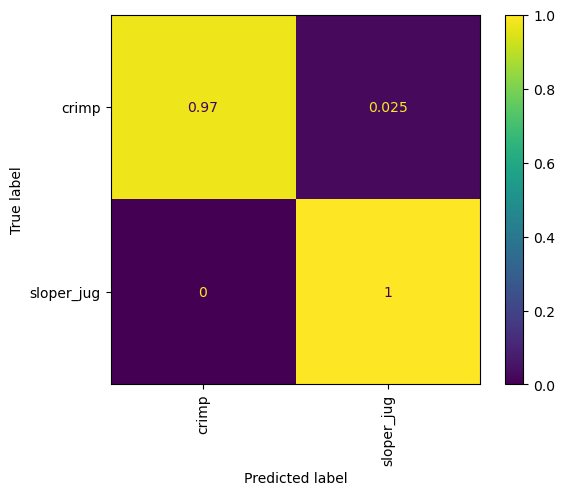

In [83]:
# load best model
model.load_state_dict(torch.load(model_path))
model.eval()

with torch.no_grad():
    outputs = model(data_test)
    _, prediction = torch.max(outputs, 1)
    _, true_labels = torch.max(labels_test, 1)
    def transform_labels(labels):
        return encoder.categories_[0][np.array(labels.cpu())]
    report_cm(f'Testing with {test_person}', transform_labels(true_labels), transform_labels(prediction), encoder.categories_[0])